# Candidate Test 2022 Analysis Part 1

This exercise focuses on the candidate tests from two television networks: DR and TV2. Data from both tests have been given on a scale of five responses (-2, -1, 0, 1, 2).

---

There are 6 datasets included in this exercise:

- `alldata.xlsx`: Contains responses from both TV stations.
- `drdata.xlsx`: Contains responses from DR.
- `drq.xlsx`: Contains questions from DR.
- `tv2data.xlsx`: Contains responses from TV2.
- `tv2q.xlsx`: Contains questions from TV2.
- `electeddata.xlsx`: Contains responses from both TV stations for candidates who were elected to the parliament. Note that 9 members are missing; 7 of them didn't take any of the tests. Additionally, some notable figures like Mette F. and Lars Løkke did not participate in any of the tests.

---

It's entirely up to you how you approach this data, but at a *minimum*, your analysis should include:
- Age of the candidates grouped by parties.
- An overview of the most "confident" candidates, i.e., those with the highest proportion of "strongly agree" or "strongly disagree" responses.
- Differences in responses between candidates, both inter-party and intra-party, along with an explanation of which parties have the most internal disagreements.
- Classification models to predict candidates' party affiliations. Investigate if there are any candidates who seem to be in the "wrong" party based on their political landscape positions. You must use the following three algorithms: **Decision Tree, Random Forrest, and Gradient Boosted Tree**, and **two other** classification algorithms of your choice, i.e. a total of 5 models are to be trained.

---

The following parties are represented:

| Party letter | Party name | Party name (English) | Political position |
| :-: | :-: | :-: | :-: |
| A | Socialdemokratiet | Social Democrats | Centre-left |
| V | Venstre | Danish Liberal Party | Centre-right |
| M | Moderaterne | Moderates | Centre-right |
| F | Socialistisk Folkeparti | Socialist People's Party | Left-wing |
| D | Danmarksdemokraterne | Denmark Democrats | Right-wing |
| I | Liberal Alliance | Liberal Alliance | Right-wing |
| C | Konservative | Conservative People's Party | Right-wing |
| Æ | Enhedslisten | Red-Green Alliance | Far-left |
| B | Radikale Venstre | Social Liberal Party | Centre-left |
| D | Nye Borgerlige | New Right | Far-right |
| Z | Alternativet | The Alternative | Centre-left |
| O | Dansk Folkeparti | Danish People's Party | Far-right |
| G | Frie Grønne | Free Greens | Centre-left |
| K | Kristendemokraterne | Christian Democrats | Centre-right |

Below you can see the results and the colors chosen to represent the parties. Use these colors in your analysis above.

![Alt text](image-1.png)


Others have undertaken similar analyses. You can draw inspiration from the following (use Google tranlsate if your Danish is rusty):

- [Analysis of where individual candidates stand relative to each other and their parties](https://v2022.dumdata.dk/)
- [Candidate Test 2022 – A deep dive into the data](https://kwedel.github.io/kandidattest2022/)
- [The Political Landscape 2019](https://kwedel.github.io/kandidattest2019/)



In [20]:
#pip install pandas
# pip install scikit-learn
# pip install wordcloud
import pandas as pd
import sklearn as sk

# load the data
responsesFromBothDRTV2 = pd.read_excel('alldata.xlsx')
responsesFromBothDRTV2.rename(columns={'alder': 'Age', 'storkreds': 'District', 'navn': 'Name', 'parti': 'Party'}, inplace=True)
responsesFromDR=pd.read_excel('drdata.xlsx')
responsesFromDR.rename(columns={'navn': 'Name', 'parti': 'Party' }, inplace=True)
questionsFromDR=pd.read_excel('drq.xlsx')
questionsFromDR.rename(columns={'ID': 'id', }, inplace=True)
questionsFromTV2=pd.read_excel('tv2q.xlsx')
questionsFromTV2.rename(columns={'question': 'Question', 'header': 'Title'}, inplace=True)
responsesFromTV2=pd.read_excel('tv2data.xlsx')
responsesFromTV2.rename(columns={'navn': 'Name', 'parti': 'Party', 'alder': 'Age', 'storkreds': 'District'}, inplace=True)
electedData=pd.read_excel('electeddata.xlsx')
electedData.rename(columns={'navn': 'Name', 'parti': 'Party', 'alder': 'Age', 'storkreds': 'District'}, inplace=True)

# Define DR and TV2 question columns based on the given IDs
dr_questions = ['530', '531', '533', '534', '535', '537', '538', '540', '541', '543', '544', 
                '545', '546', '547', '548', '550', '551', '552', '553', '555', '556', '557', 
                '559', '561', '563']  # DR question columns
tv2_questions = ['1a', '1b', '2a', '2b', '3a', '3b', '4a', '4b', '5a', '5b', '6a', '6b', 
                 '7a', '7b', '8a', '8b', '9a', '9b', '10a', '10b', '11a', '11b', '12a', '12b']

#Creating DR dataframe with questions+Responses
"""Note: Missing ages and districts for candidates
Only place to look for arguments for and against"""
responses_melted = responsesFromDR.melt(
    id_vars=['Name', 'Party'],  # Use Name and Party (adjust if needed)
    value_vars=dr_questions,  # Use only existing question ID columns
    var_name='id',
    value_name='response'
)
responses_melted['id'] = responses_melted['id'].astype(int)

merged_DRdata = pd.merge(
    responses_melted, 
    questionsFromDR, 
    left_on='id',  # Column in the melted DataFrame
    right_on='id',  # Column in the questions DataFrame
    how='left'  # Use a left join to keep all responses
)
# Remove the 'Wordmerge'(only contains 1 value:(0) and 'Info'(only contains 1 value: NAn) columns & 'Rule'(only contains 1 value: 'FT')
#'ID_CandidateQuestionType (only contained 1 value) & QuestionListData (only contains Nan)
merged_DRdata.drop(columns=['WordMerger','Info','ID_CandidateQuestionType', 'QuestionListData'], inplace=True, errors='ignore')
print(merged_DRdata.head())
print(merged_DRdata.columns.tolist())

#Creating TV2 Dataframe
"""Note: Best place to look at age and district as these columns do not exist in the response from DR
Removal of type column and depends column is recommend as 'type' only contains one value: 'rate' as we only have 
data from ratings in this dataframe. 
Depends column allows candidate to select an area where they want their answer to apply(not relevant for many of the 
questions so NaN is a popular response). This column only contains Nan when merged with responses so it should be dropped as it 
is only relevant for questions we do not have data on 
"""
responses_meltedTV2 = responsesFromTV2.melt(
    id_vars=['Name', 'Party', 'Age', 'District'], 
    value_vars=tv2_questions,  
    var_name='id',
    value_name='response'
)
responses_meltedTV2['id'] = responses_meltedTV2['id'].astype(str)
questionsFromTV2['id'] = questionsFromTV2['id'].astype(str)

merged_TV2data = pd.merge(responses_meltedTV2, questionsFromTV2, left_on='id', right_on='id', how='left')

# Remove the 'depends' and 'type' columns 
merged_TV2data.drop(columns=['depends', 'type'], inplace=True, errors='ignore')

print(merged_TV2data.head())
print(merged_TV2data.columns.tolist())


# Dataframe for elected data
"""Results from the candidates that were elected - 169 Cnadidates included (9 missing)
Elected responses contains names, ages, parties and districts"""
responses_melted_DR_Elected = electedData.melt(
    id_vars=['Name', 'Party', 'Age', 'District'],  # Keep these columns unchanged
    value_vars=dr_questions,  # Use only DR question columns
    var_name='id',  # Create an 'id' column for the question ID
    value_name='response'  # Store the response value in the 'response' column
)
responses_melted_DR_Elected['id'] = responses_melted_DR_Elected['id'].astype(str)
responses_melted_TV2_Elected = electedData.melt(
    id_vars=['Name', 'Party', 'Age', 'District'],  
    value_vars=tv2_questions,  
    var_name='id',  
    value_name='response'  
)
responses_melted_TV2_Elected['id'] = responses_melted_TV2_Elected['id'].astype(str)

combined_elected_responses = pd.concat([responses_melted_DR_Elected, responses_melted_TV2_Elected], ignore_index=True)
# Ensure the 'ID' in DR and 'id' in TV2 question metadata are the same type (string)
questionsFromDR['id'] = questionsFromDR['id'].astype(str)
questionsFromTV2['id'] = questionsFromTV2['id'].astype(str)


# Step 4: Concatenate DR and TV2 question metadata
combined_questions = pd.concat([questionsFromDR[['id', 'Question']], questionsFromTV2[['id', 'Question']]], ignore_index=True)

# Merge the concatenated questions with the combined responses
combined_elected_responses = pd.merge(
    combined_elected_responses, 
    combined_questions,  # Concatenated question text from both DR and TV2
    on='id',  # Merge on the 'id' column (now shared by both DR and TV2)
    how='left'  # Left join to keep all responses
)

print(combined_elected_responses.head())
print(combined_elected_responses.columns.tolist())

#Creating Combined Responses - the bothDRTV2 dataframe with questions and responses
"""Things to note:
There are more question ID's than there are response IDs so not all questions we have answers to . The questions we do not have responses to are automatically filtered out of this dataframe
There is no age or district column in the responses from DR´so it may make sense to drop those columns when looking at combined data Find it below"""
responses_melted = responsesFromBothDRTV2.melt(
    id_vars=['Name', 'Party', 'Age', 'District'],  # Keep candidate information
    value_vars=dr_questions + tv2_questions,  # Use both DR and TV2 question IDs
    var_name='id',  # Create a single 'id' column for both DR and TV2 question IDs
    value_name='response'  # Store responses in 'response' column
)



# Step 4: Merge the responses with the combined questions on 'id'
final_combined_all_candidate_data = pd.merge(
    responses_melted, 
    combined_questions,  # Combine the question text
    on='id',  # Merge on 'id' to match questions with responses
    how='left'  # Use left join to retain all responses
)

# Remove the 'Age' and 'District' columns because they are only in the TV2 dataframe
# final_combined_all_candidate_data.drop(columns=['Age', 'District'], inplace=True, errors='ignore')

# Step 5: View the final combined data
print(final_combined_all_candidate_data.head())
print(final_combined_all_candidate_data.columns.tolist())


                       Name                    Party   id  response  \
0      Lars Philipsen Prahm              Moderaterne  530        -1   
1             Karsten Hønge  Socialistisk Folkeparti  530         2   
2  Martin Kelleher-Petersen             Alternativet  530         2   
3    Nicklas Gjedsig Larsen             Alternativet  530         2   
4            Tom Gillesberg                Løsgænger  530         1   

             Title                                           Question  \
0  KLIMA OG ENERGI  Danmark skal bruge flere penge på at styrke to...   
1  KLIMA OG ENERGI  Danmark skal bruge flere penge på at styrke to...   
2  KLIMA OG ENERGI  Danmark skal bruge flere penge på at styrke to...   
3  KLIMA OG ENERGI  Danmark skal bruge flere penge på at styrke to...   
4  KLIMA OG ENERGI  Danmark skal bruge flere penge på at styrke to...   

                                         ArgumentFor  \
0  Den kollektive trafik bør være billig og tilgæ...   
1  Den kollektive traf

In [21]:
import pandas as pd

all_data = pd.read_excel('alldata.xlsx')
dr_data = pd.read_excel('drdata.xlsx')
drq = pd.read_excel('drq.xlsx')
tv2_data = pd.read_excel('tv2data.xlsx')
tv2q = pd.read_excel('tv2q.xlsx')

print(all_data)

print(dr_data)

print(drq)

print(tv2_data)

print(tv2q)

#

# Loading the entire Excel file
df = pd.read_excel('alldata.xlsx')

# Drop the columns by name (e.g., exclude 'Column1' and 'Column3')
df_filtered = df.drop(columns=['parti', 'storkreds', 'alder'])

# Print the resulting DataFrame
print(df_filtered)

#

import pandas as pd

# Loading the Excel file into a DataFrame
df = pd.read_excel('alldata.xlsx')

# Defining a function to count 2's and -2's in each row ("strongly agree" and "strongly disagree" answers)
def count_values(row):
    count_2 = (row == 2).sum()  # Count occurrences of 2
    count_neg_2 = (row == -2).sum()  # Count occurrences of -2
    return pd.Series({'Count_2': count_2, 'Count_-2': count_neg_2})

# Applying the function row-wise, excluding the irrelevant, non-numerical columns
df_counts = df.drop(columns=['navn', 'parti', 'storkreds', 'alder']).apply(count_values, axis=1)

# Concatenating the counts with the 'navn' column
df_final = pd.concat([df['navn'], df_counts], axis=1)

# Grouping by 'navn' if there are multiple rows with the same name
df_grouped = df_final.groupby('navn').sum().reset_index()

# Creating a new column 'Total_Count' that sums 'Count_2' and 'Count_-2'
df_grouped['Total_Count'] = df_grouped['Count_2'] + df_grouped['Count_-2']

# Sorting the DataFrame by 'Total_Count' in descending order
df_sorted = df_grouped.sort_values(by='Total_Count', ascending=False)

# Printing the first 50 rows of the sorted DataFrame
print(df_sorted.head(50))




     530  531  533  534  535  537  538  540  541  543  ...  9a  9b  10a  10b  \
0     -1   -2    1   -2    2    1   -2    1    1    2  ...   2   0    1   -2   
1      2    2   -1   -2   -1   -2    1   -2    2   -2  ...  -2   0   -1    2   
2      2    1   -2   -2    1   -2    1   -1    1   -1  ...  -1  -2    0    2   
3      2    1   -2   -1    1    1    1    1    1   -2  ...  -2   2    2    2   
4      1    1   -2    2   -2    1   -2    1    2   -2  ...  -2   0   -1    0   
..   ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ..  ..  ...  ...   
862    1    1    1   -2    2   -1    1   -2    1    1  ...   1   2   -1    2   
863    1   -2   -2   -2    1   -2   -1   -2   -2   -2  ...  -1   0   -1    2   
864    1    1    1   -2    2   -1    1   -1   -1    1  ...  -1   0   -1    2   
865    1   -1    1   -2    1   -1   -1   -1   -1    1  ...   0   0    0    2   
866    1    1   -1   -2    1   -1    1   -1    1   -1  ...  -2  -1   -1    2   

     11a  11b  12a  12b                

In [22]:
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.spatial.distance import pdist, squareform


all_data = pd.read_excel("alldata.xlsx")
dr_data = pd.read_excel("drdata.xlsx")
dr_questions = pd.read_excel("drq.xlsx")
elected_data = pd.read_excel("electeddata.xlsx")
tv2_data = pd.read_excel("tv2data.xlsx")
tv2_questions = pd.read_excel("tv2q.xlsx")

#getting an overview of how data looks and column names
# print("All data:\n", all_data.head())
# print("DR data:\n", dr_data.head())
# print("DR questions:\n", dr_questions.head())
# print("Elected data:\n", elected_data.head())
# print("TV2 data:\n", tv2_data.head())
# print("TV2 questions:\n", tv2_questions.head())


# Differences in responses between candidates, inter-party & intra-party, explain which parties have the most internal disagreements.

#dropping columns which do not contain responses
response_columns = all_data.columns.drop(['navn', 'parti', 'storkreds', 'alder'])
#check - print(response_columns)

#grouping columns by the party and calculating variance 
intraparty_variation = all_data.groupby('parti')[response_columns].var()

#summing the variance across all questions -> shows the overall measure of disagreement for each party
intraparty_variation['total_variance'] = intraparty_variation.sum(axis=1) # axis=1 tells pandas to sum across columns for each row, in this case - sums the variance of responses for each question within the same party.

#sort by total variance to see which parties have the most internal disagreements
intraparty_variation_sorted = intraparty_variation[['total_variance']].sort_values(by='total_variance', ascending=False)

print("Intraparty:\n", intraparty_variation_sorted)




Intraparty:
                                              total_variance
parti                                                      
Løsgænger                                        129.000000
Kristendemokraterne                               54.930314
Alternativet                                      44.522388
Dansk Folkeparti                                  42.531463
Det Konservative Folkeparti                       42.482117
Moderaterne                                       41.904762
Radikale Venstre                                  39.376300
Venstre                                           36.756598
Socialdemokratiet                                 35.805667
Frie Grønne, Danmarks Nye Venstrefløjsparti       31.863077
Liberal Alliance                                  31.610559
Enhedslisten                                      28.037023
Socialistisk Folkeparti                           24.345135
Danmarksdemokraterne                              20.447447
Nye Borgerlige             

By analyzing internal disagreements, we can see that Løsgænger has the highest total variance in member responses, which indicates substantial disagreements on key issues. Due to the high total variance, it can be inferred that the members have very diverse opinions, which might make coming to agreements in political decisions challenging. 


Interparty:
                                              average_response
parti                                                        
Moderaterne                                          0.315841
Socialistisk Folkeparti                              0.252770
Socialdemokratiet                                    0.247947
Alternativet                                         0.215656
Kristendemokraterne                                  0.181730
Radikale Venstre                                     0.175754
Dansk Folkeparti                                     0.131195
Enhedslisten                                         0.095422
Frie Grønne, Danmarks Nye Venstrefløjsparti          0.091837
Løsgænger                                           -0.013605
Venstre                                             -0.028912
Det Konservative Folkeparti                         -0.056851
Danmarksdemokraterne                                -0.113072
Nye Borgerlige                                      -0.1

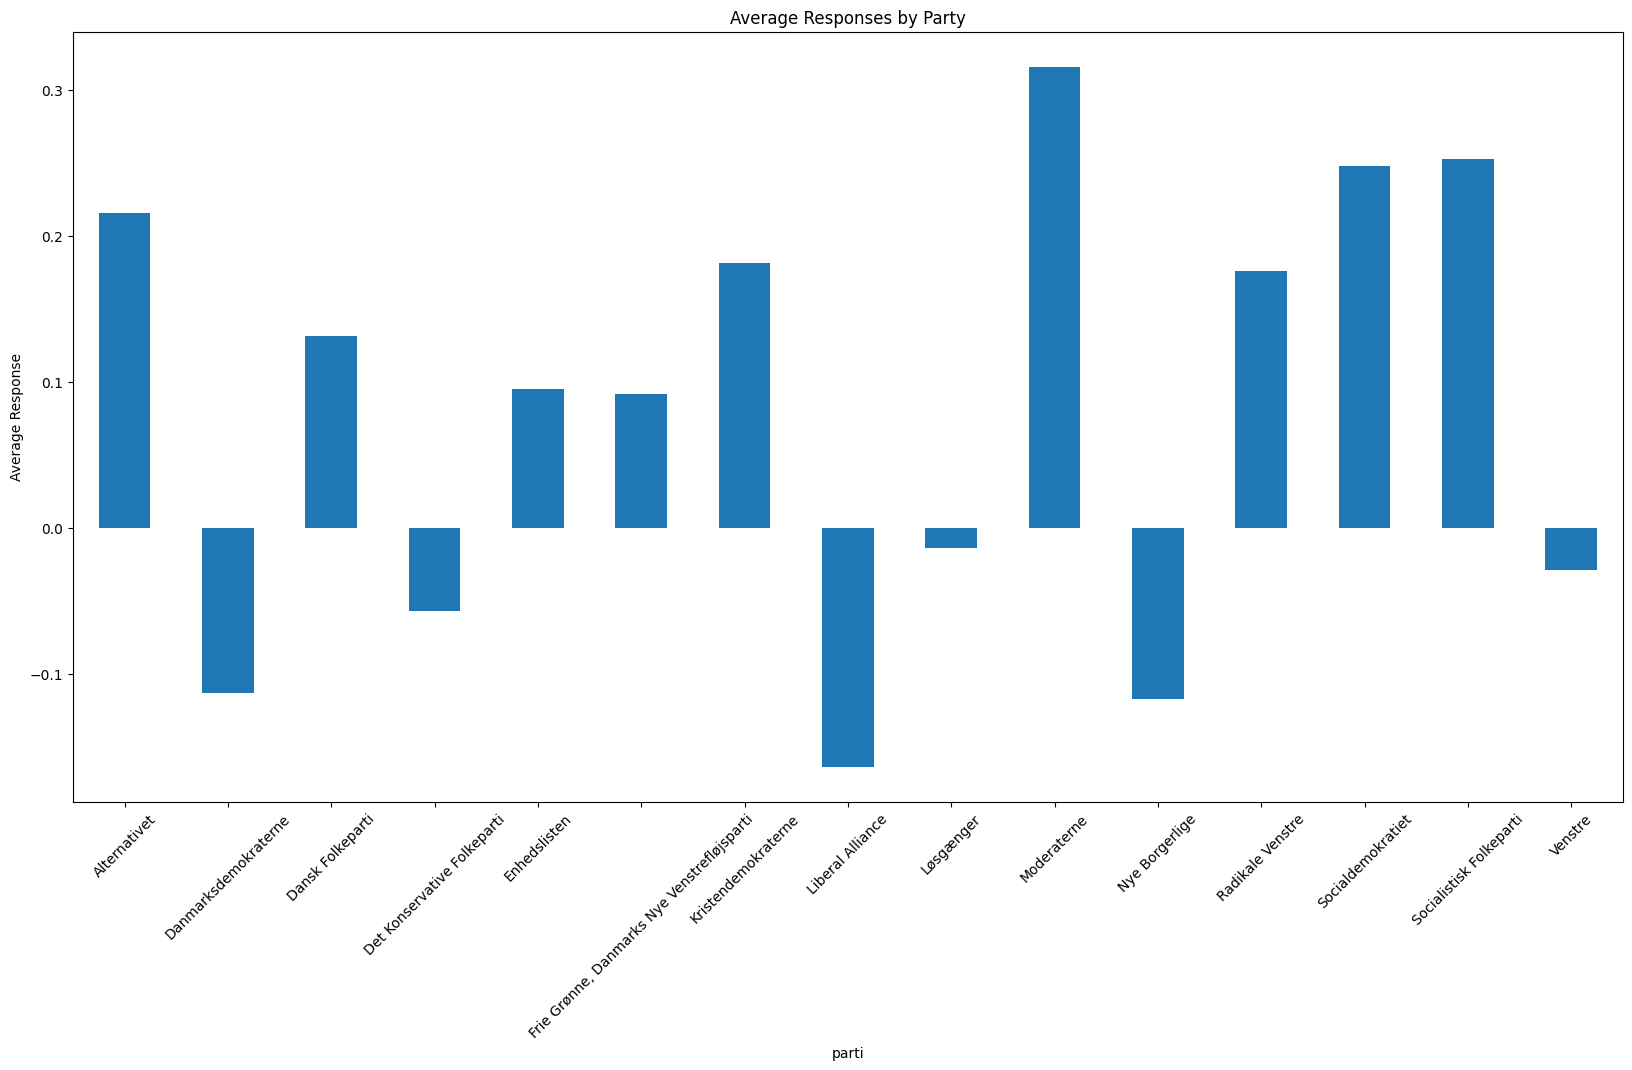

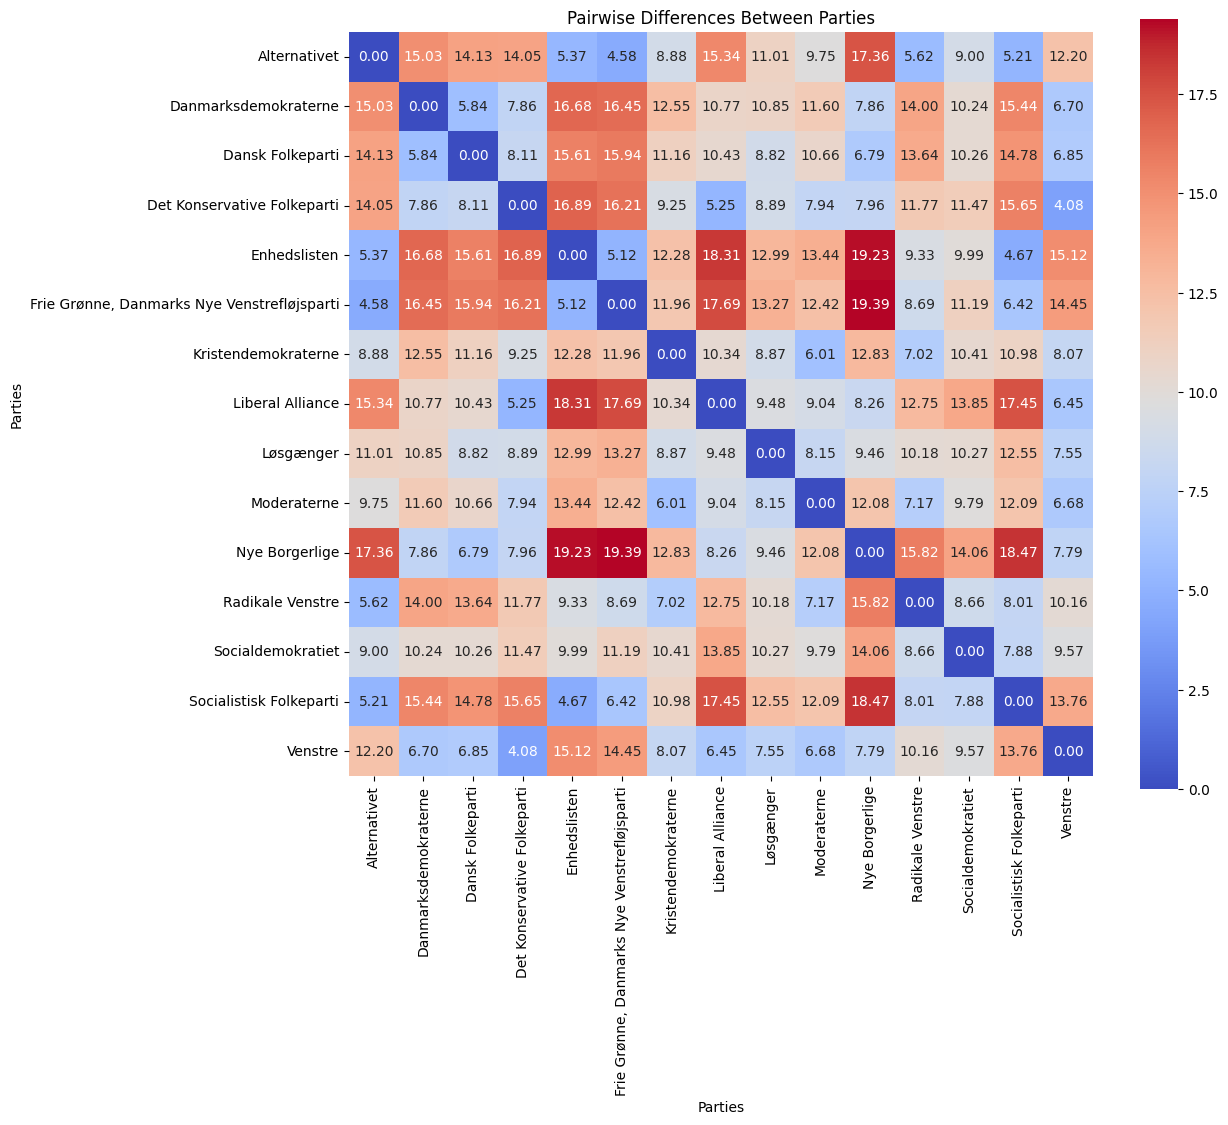

In [23]:
#doing the same for intraparty differences

interparty_means = all_data.groupby('parti')[response_columns].mean()

#get the overall average response across all questions for each party
interparty_means['average_response'] = interparty_means.mean(axis=1)

#sort parties by their overall average response
interparty_means_sorted = interparty_means[['average_response']].sort_values(by='average_response', ascending=False)

#display the sorted interparty differences
print("\nInterparty:\n", interparty_means_sorted)


interparty_means['average_response'].plot(kind='bar', figsize=(20, 10))
plt.title('Average Responses by Party')
plt.ylabel('Average Response')
plt.xticks(rotation=45)
plt.show()

distance_matrix = pdist(interparty_means, metric='euclidean')
distance_df = squareform(distance_matrix)

# Convert to DataFrame for better readability
distance_df = pd.DataFrame(distance_df, index=interparty_means.index, columns=interparty_means.index)

# Sort the distance matrix for easier interpretation
sorted_distance_df = distance_df.sort_index(axis=1).sort_index(axis=0)

# Visualize the distance matrix using a heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(sorted_distance_df, annot=True, cmap='coolwarm', fmt=".2f", square=True)
plt.title('Pairwise Differences Between Parties')
plt.xlabel('Parties')
plt.ylabel('Parties')
plt.show()




Number of rows where age is 0: 18
                                  mean  min  max
parti                                           
Alternativet                 48.416667   21   79
Danmarksdemokraterne         51.216216   24   69
Dansk Folkeparti             46.048387   20   75
Det Konservative Folkeparti  44.600000   20   66
Enhedslisten                 42.466667   19   79
Frie Grønne                  33.612903   20   62
Kristendemokraterne          51.877551   21   74
Liberal Alliance             38.392405   18   72
Løsgænger                    50.500000   40   58
Moderaterne                  44.812500   19   78
Nye Borgerlige               48.730769   20   70
Radikale Venstre             45.521127   21   78
Socialdemokratiet            45.627907   20   78
Socialistisk Folkeparti      42.350649   20   68
Venstre                      47.260870   18   72


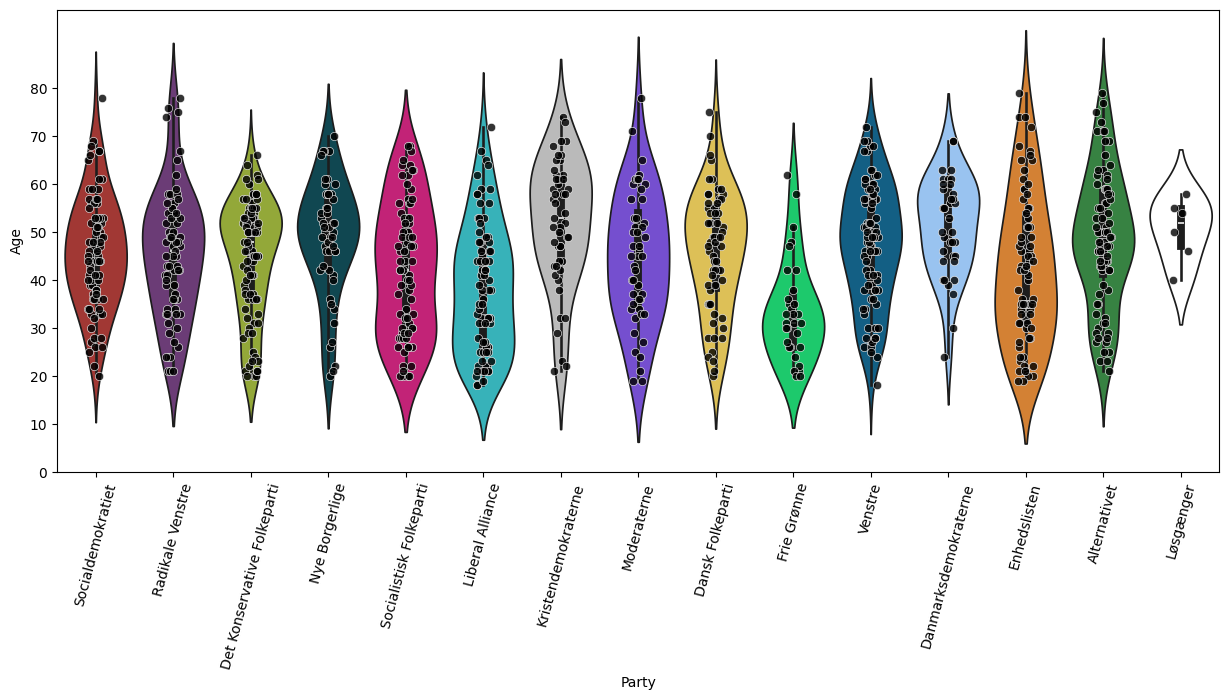

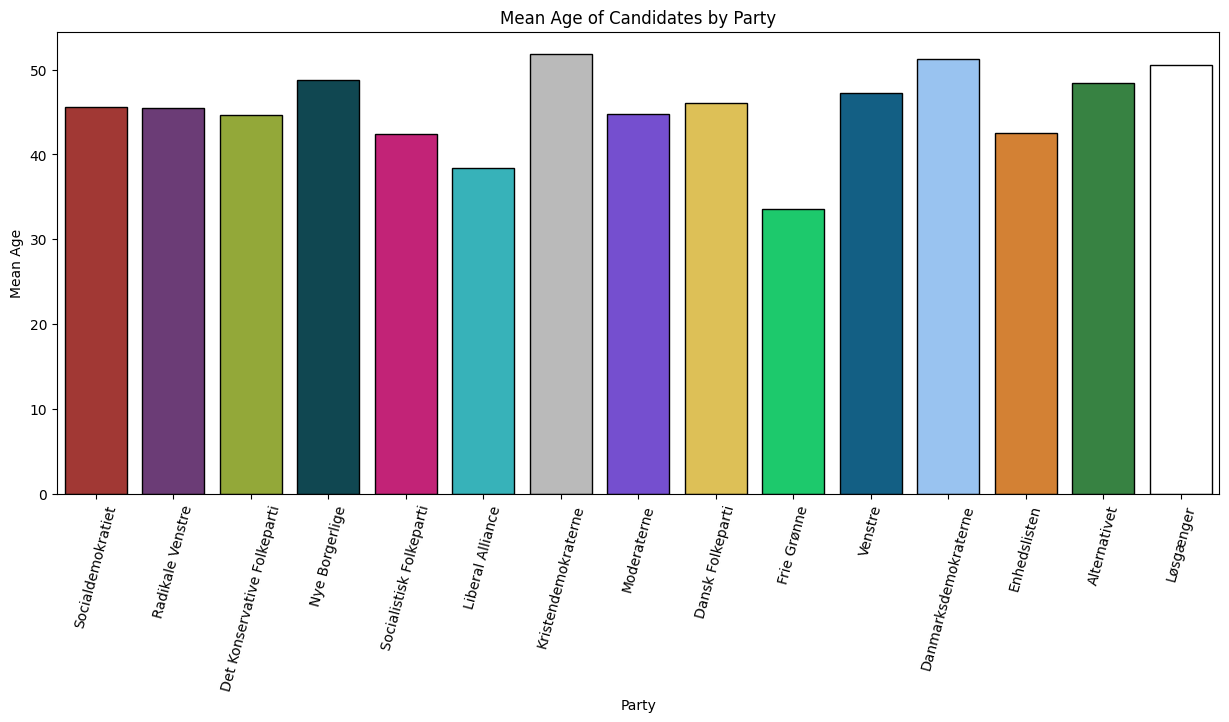

In [24]:
import pandas as pd
import sklearn as sk
import seaborn as sns
import matplotlib.pyplot as plt

data5= pd.read_excel('tv2data.xlsx')
danskcolor = {"Socialdemokratiet": '#b32722',
"Radikale Venstre" : '#713280',
"Det Konservative Folkeparti": '#9eba27',
"Nye Borgerlige": '#054f5c',
"Socialistisk Folkeparti" : '#dd0878',
"Liberal Alliance": '#21c6cf',
"Kristendemokraterne": '#bababa',
"Moderaterne": '#6c39e5',
"Dansk Folkeparti": '#f3cd41',
"Frie Grønne": '#00e66a',
"Venstre": '#006697',
"Danmarksdemokraterne": '#8ac3ff',
"Enhedslisten": '#ed8019',
"Alternativet": '#2a8f39',
"Løsgænger": '#ffffff'}
ordered_parties = list(danskcolor.keys())

data_politician_age = data5[['parti', 'alder']]
data_politician_age.loc[:, 'parti'] = data_politician_age['parti'].replace('Frie Grønne, Danmarks Nye Venstrefløjsparti', 'Frie Grønne')

count_deleted_rows = data_politician_age[data_politician_age['alder'] == 0].shape[0]
print(f"Number of rows where age is 0: {count_deleted_rows}")
data_politician_age = data_politician_age[data_politician_age['alder'] != 0]


grouped_data_politician_age = data_politician_age.groupby('parti')['alder'].agg(['mean', 'min', 'max'])
print(grouped_data_politician_age)


plt.figure(figsize=(15, 6))
sns.violinplot(x='parti', y='alder', hue='parti', data=data_politician_age, palette=danskcolor, legend=False, order=ordered_parties)
sns.stripplot(x='parti', y='alder', data=data_politician_age, color='black', alpha=0.8, size=6, jitter=True, edgecolor='white', linewidth=0.5)
plt.xlabel('Party')
plt.yticks(range(0, data_politician_age['alder'].max() + 10, 10))
plt.xticks(rotation=75)
plt.ylabel('Age')
plt.show()


plt.figure(figsize=(15, 6))
sns.barplot(x=grouped_data_politician_age.index, y=grouped_data_politician_age['mean'], hue=grouped_data_politician_age.index, palette=danskcolor, edgecolor='black',order=ordered_parties)
plt.title('Mean Age of Candidates by Party')
plt.xlabel('Party')
plt.ylabel('Mean Age')
plt.xticks(rotation=75)
plt.show()

In [35]:
# Gradient Bosting Tree
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder

final_combined_all_candidate_data['Party'] = final_combined_all_candidate_data['Party'].astype('category').cat.codes
label_encoder = LabelEncoder()
final_combined_all_candidate_data['District'] = label_encoder.fit_transform(final_combined_all_candidate_data['District'])

# Select relevant columns 
X = final_combined_all_candidate_data[[ 'response', 'Age' , 'District']]
y = final_combined_all_candidate_data['Party']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = GradientBoostingClassifier()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.2f}")
# Original Accuracy 0.14

# Analyse with parameter works the best
""" param_dist = {
    'n_estimators': [50, 100, 150],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 5, 7],
    'subsample': [0.6, 0.8, 1.0]
}
random_search = RandomizedSearchCV(GradientBoostingClassifier(), param_dist, cv=3, n_iter=10, scoring='accuracy', random_state=42)
random_search.fit(X_train, y_train)
print(f"Best parameters: {random_search.best_params_}")
print(f"Best cross-validation accuracy: {random_search.best_score_}")
best_model = random_search.best_estimator_
y_pred = best_model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy after tuning: {accuracy:.2f}") """

X_2 = final_combined_all_candidate_data[[ 'response', 'Age' , 'District']]
y_2 = final_combined_all_candidate_data['Party']

X_train_2, X_test_2, y_train_2, y_test_2 = train_test_split(X_2, y_2, test_size=0.2, random_state=42)

model = GradientBoostingClassifier(  
    subsample=0.8,
    n_estimators=150,
    max_depth=5,
    learning_rate=0.2)
model.fit(X_train_2, y_train_2)
y_pred_2 = model.predict(X_test_2)
accuracy = accuracy_score(y_test_2, y_pred_2)
print(f"Accuracy: {accuracy:.2f}")


Accuracy: 0.41
Accuracy: 0.56
